<h1 align="center">
Projet 6 :  
Nematode status assay</h1>


Hieu Minh DANG, Cyr BATANGA LOKO et Lilian GUITART ARNAU  
  
Supperviés par Mathilde DUPOUY, Robin TROMBETTA

## Introduction

Ce projet est un projet de traitement d’images microscopiques du nématode Caenorhabditis elegans, utilisé comme organisme modèle dans un criblage visant à identifier de nouveaux agents anti-infectieux. Les nématodes ont été exposés à un pathogène, puis soit laissés sans traitement, soit traités par un antibiotique, induisant des différences morphologiques observables entre individus vivants et morts.  
  
L’objectif du projet est de concevoir un pipeline permettant la segmentation automatique des nématodes, l’extraction de descripteurs géométriques pertinents pour caractériser leur état physiologique, et la validation statistique de l’effet du traitement à partir des mesures obtenues.

## Pipeline de traitement d'images

### Imports des librairies

In [411]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from skimage import filters, segmentation, feature, measure
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image
from collections import Counter
from skimage.morphology import skeletonize
import networkx as nx
from scipy import stats
import statsmodels.formula.api as smf

### Import des images

Les images sont chargées par ordre alphabétique pour conserver leur ordre.

In [412]:
l_img = []

for filename in sorted(os.listdir("Data")): # pour avoir les images dans le bon ordre (12 tests puis 12 contrôles)
    img_path = os.path.join("Data", filename)
    img = np.array(Image.open(img_path))
    l_img.append(img)

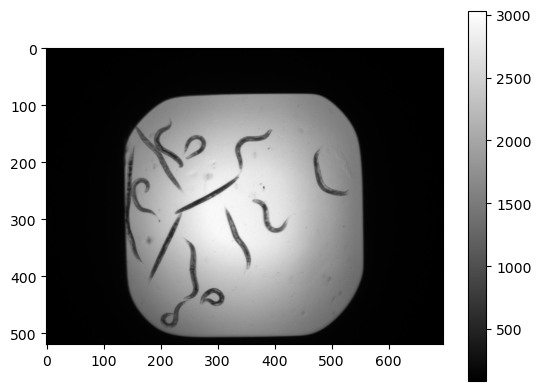

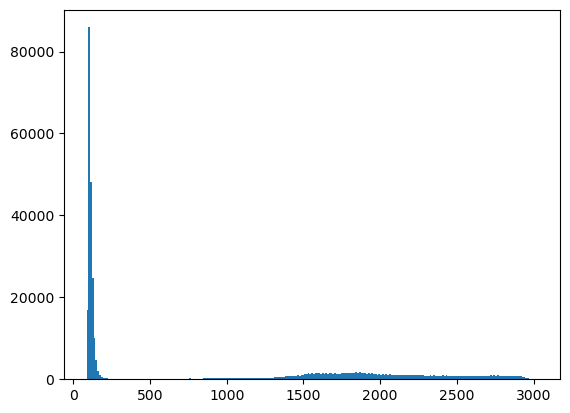

In [413]:
plt.imshow(l_img[0], cmap="gray")
plt.colorbar()
plt.show()

plt.hist(l_img[0].flatten(), bins = 255)
plt.show()

### Preprocessing des images

#### Dilatation des histogrammes

On ramène les valeurs d'intensité des pixels entre 0 et 255 par dilatation des histogrammes.

In [414]:
def stretch(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (255*((img-mini)/(maxi-mini)))

In [415]:
l_img_stretched = []

for img in l_img :
    l_img_stretched.append(stretch(img).astype(int).copy())

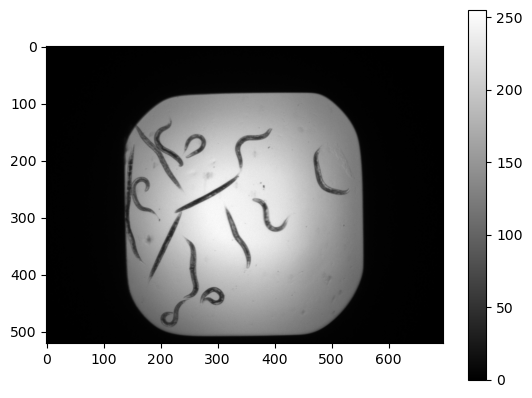

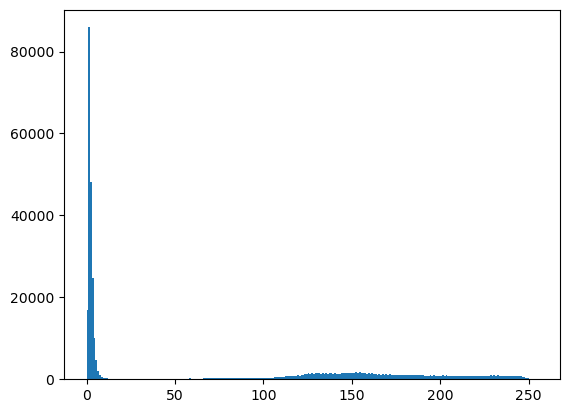

In [416]:
plt.imshow(l_img_stretched[0], cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(l_img_stretched[0].flatten(), bins = 255)
plt.show()

### Seuillage

Pour augmenter, uniformiser le contraste, et même commencer à isoler les nématodes, on cherche à déterminer un seuil d'intensité 

#### Seuil global

Aucun seuil global n'a pas pu être utilisé à cause des grandes variations de luminosité du fond dans les fenêtres d'intérêt : il y a un important effet de vignetage.

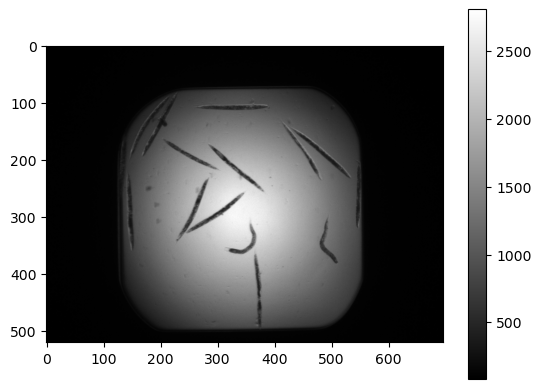

In [417]:
plt.imshow(l_img[13], cmap="gray")
plt.colorbar()
plt.show()

#### Seuil local

Un seuil local dans une fenêtre de 51 bloques est alors appliqué à l'aide de la fonction filters.threshold_local

In [418]:
l_img_local_thresholded = []

block_size = 51
for img in l_img_stretched:
    local_thresh = filters.threshold_local(img, block_size, offset=10)
    l_img_local_thresholded.append(img < local_thresh)


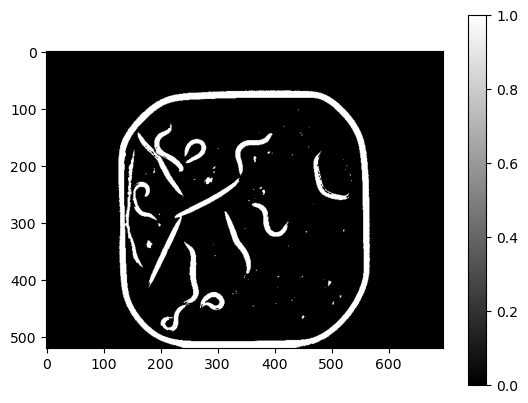

In [419]:
plt.imshow(l_img_local_thresholded[0], cmap="gray")
plt.colorbar()
plt.show()

### Supression du contour du récipiant

On constate que l'étape de seuillage fait ressortir les contours des récipiants dans chaque image.  
Pour les supprimer, ces contours sont isolés à partir des images de départ, puis dilaté à l'aide d'un kernel de 21 par 21 pixels.

In [420]:
l_window = []

window_threshold = 8

for img in l_img_stretched:
    window = img>window_threshold
    l_window.append(window)

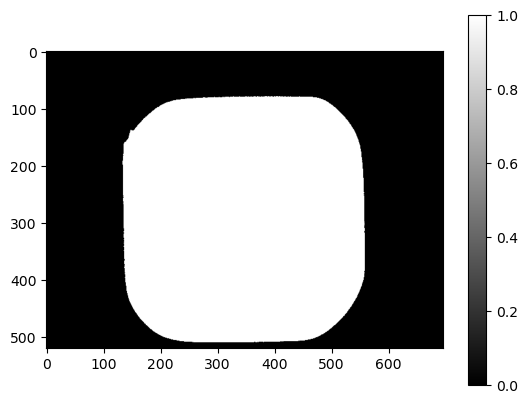

In [421]:
plt.imshow(l_window[0], cmap="gray", vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

In [422]:
l_window_countour = []

for window in  l_window :
    l_window_countour.append(stretch(filters.sobel(window))>30)


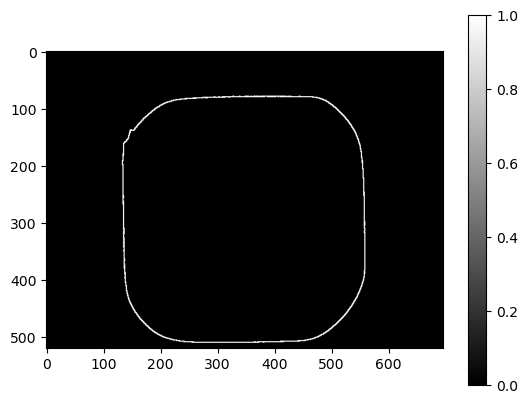

In [423]:
plt.imshow(l_window_countour[0], cmap="gray")
plt.colorbar()
plt.show()

In [424]:
l_wide_window_negative_countour = []

width = 21

for negative_countour in l_window_countour:
    l_wide_window_negative_countour.append(signal.convolve2d(negative_countour,np.ones((width,width)),mode='same')==0)


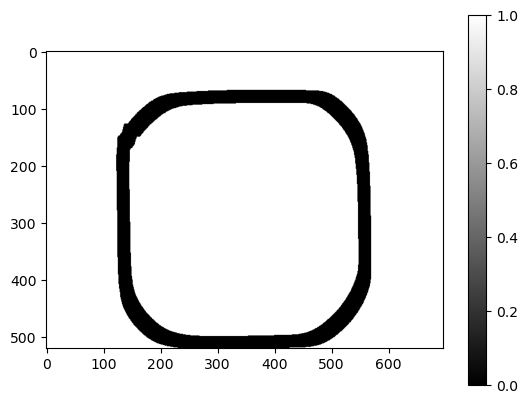

In [425]:
plt.imshow(l_wide_window_negative_countour[0], cmap="gray")
plt.colorbar()
plt.show()

Les contours obtenus sont ensuite soustraits à leurs images correspondantes obtenues après de seuillage précédent.

In [426]:
l_img_local_thresholded_nematods = []

for i,img in enumerate(l_img_local_thresholded):
    l_img_local_thresholded_nematods.append(np.multiply(np.multiply(img, l_wide_window_negative_countour[i]),l_window[i]))

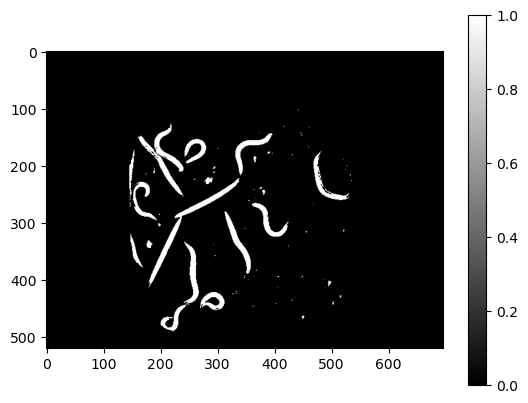

In [427]:
plt.imshow(l_img_local_thresholded_nematods[0], cmap="gray")
plt.colorbar()
plt.show()

### Opérations Morphologiques

Les images obtenues permettent une bonne segmentation des nématodes mais ceux-ci présentent parfois de larges "trous" problématiques pour les analyses futures.  
Par exemple :

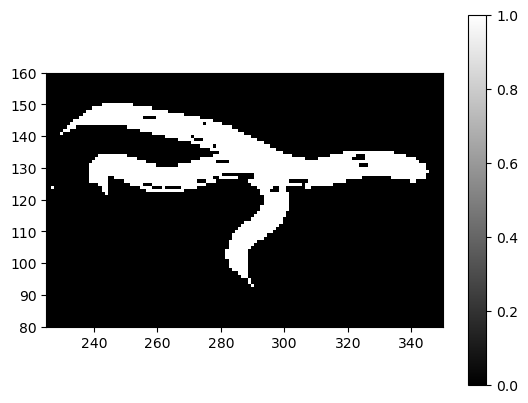

In [428]:
plt.imshow(l_img_local_thresholded_nematods[9], cmap="gray")
plt.ylim((80,160))
plt.xlim((225,350))
plt.colorbar()
plt.show()

Une succession d'érosion et de dilatation est donc réalisée pour combler ces trous.

In [429]:
def erosion(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    ero_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) < np.sum(structuring_element) :
                ero_img[i,j] = 0
            else :
                ero_img[i,j] = 1
    return ero_img


In [430]:
def dilatation(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    dil_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) > 0 :
                dil_img[i,j] = 1
            else :
                dil_img[i,j] = 0
    return dil_img


In [431]:
def multiple_erosions_and_dilataions(bin_img,l):
    for letter in l:
        if letter=='e':
            bin_img = erosion(bin_img).copy()
        elif letter=='d':
            bin_img = dilatation(bin_img).copy()
    return bin_img

In [432]:
l_img_morph = []

for img in l_img_local_thresholded_nematods:
    l_img_morph.append(multiple_erosions_and_dilataions(img,['d','d','e','e']))

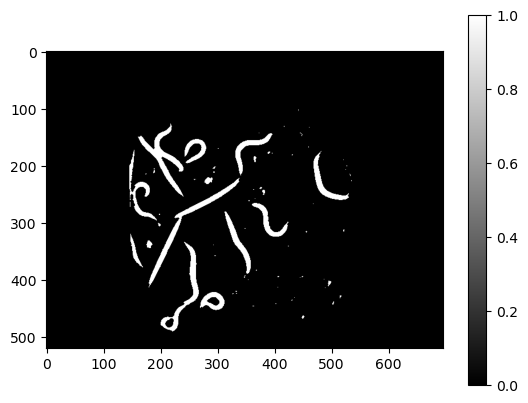

In [433]:
plt.imshow(l_img_morph[0], cmap="gray")
plt.colorbar()
plt.show()

Pour finaliser la complétion des trous sans trop dénaturer la morphologie des nématodes, notamment lorsque plusieurs d'entre eux sont supperposés, un filtre médian est appliqué.  
Ce filtre est appliqué sur une image binaire et produit donc aussi une image binaire.

In [434]:
l_img_morph_fill = []

for img in l_img_morph:
    l_img_morph_fill.append(filters.median(img))

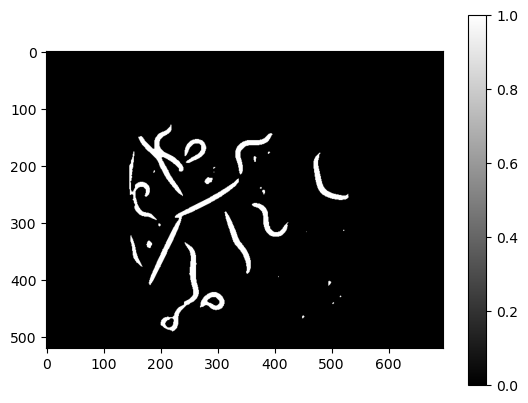

In [435]:
plt.imshow(l_img_morph_fill[0], cmap="gray")
plt.colorbar()
plt.show()

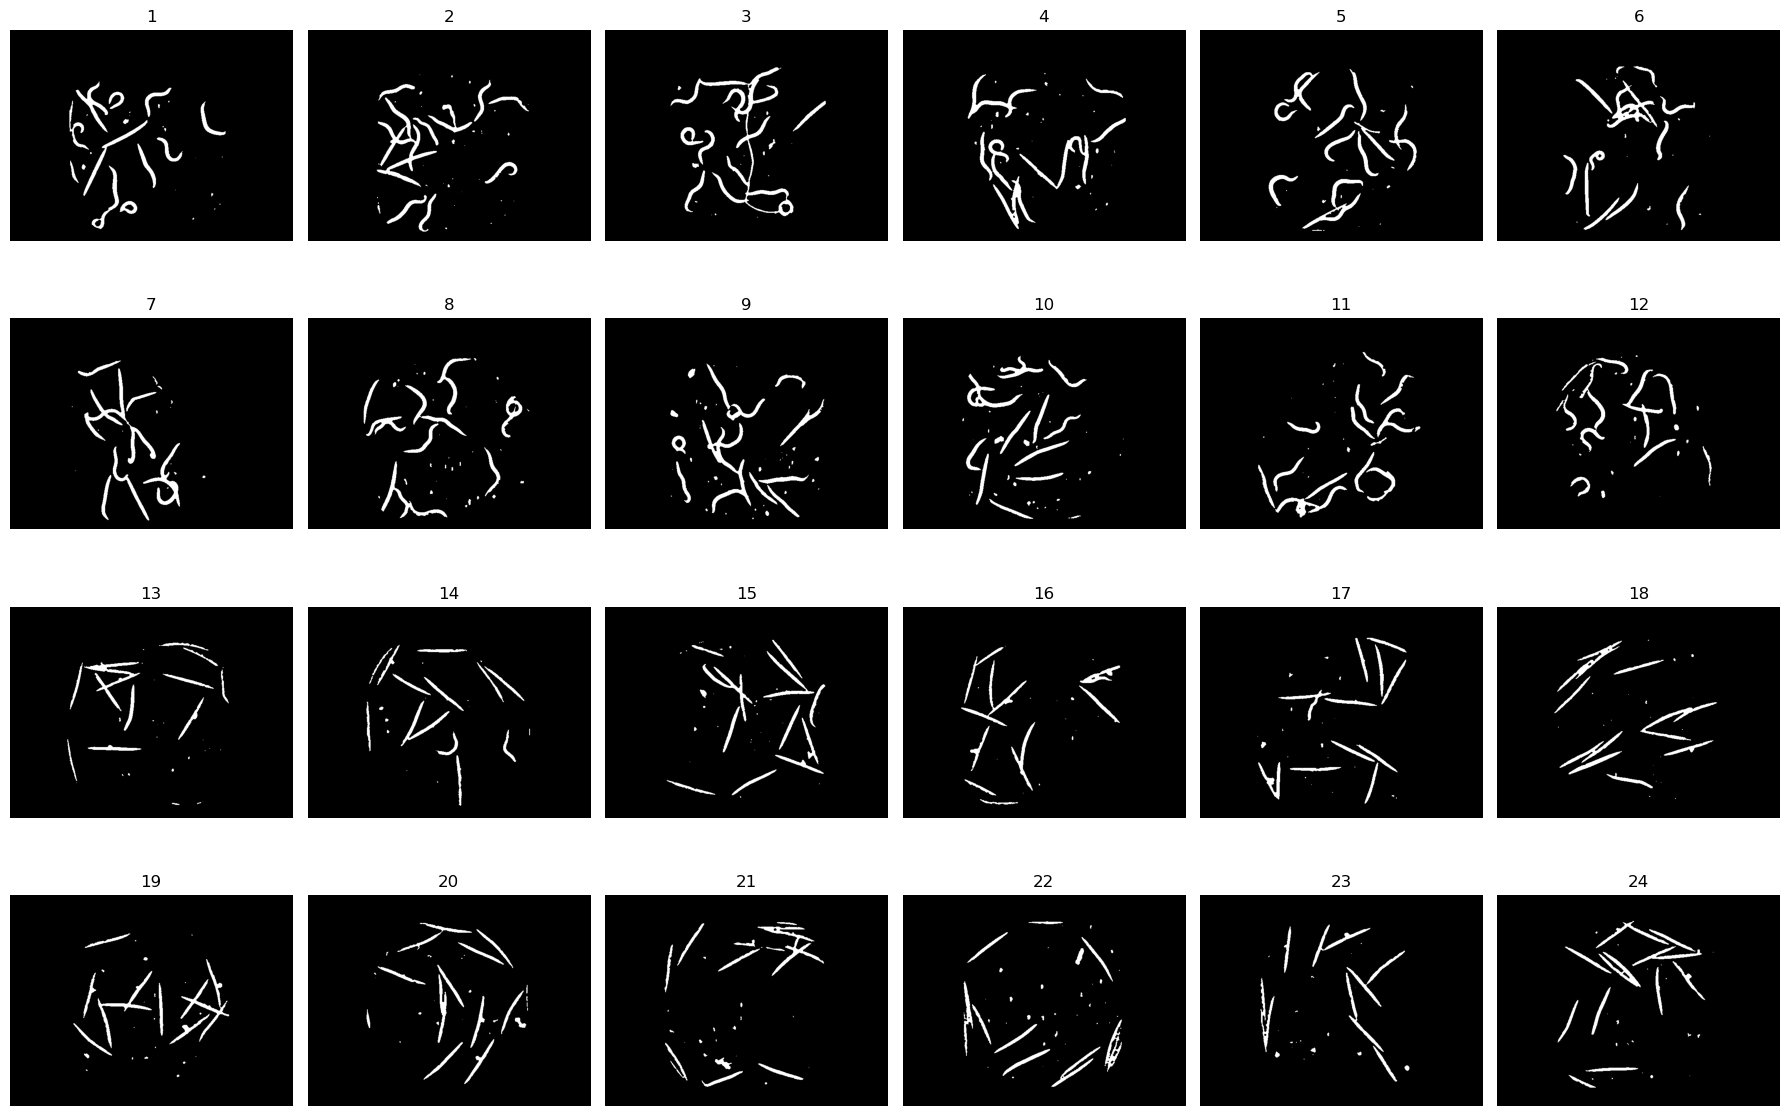

In [436]:
n = len(l_img_morph_fill)
cols = 6       
rows = 4
plt.figure(figsize=(3*cols, 3*rows))
for i, img in enumerate(l_img_morph_fill):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(i+1)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Squelettisation 

Afin à la fois de segmenter les nématodes, de gérer les cas fréquents de superposition et d'être en mesure d'analyser leurs caractéristiques géométriques, une opération de "squelettisation" est appliquée via la fonction *skeletonize* du package *skimage.morphology*

In [437]:
l_skeleton = []

for img in l_img_morph_fill:
    l_skeleton.append(skeletonize(img))

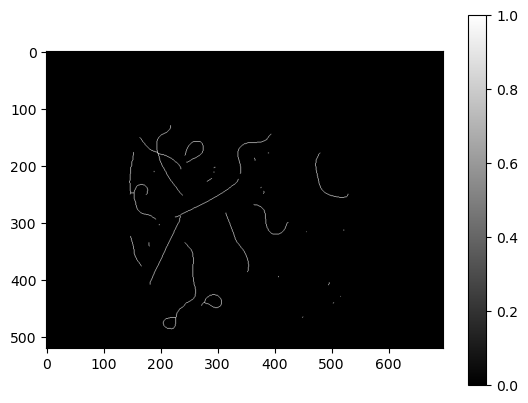

In [438]:
plt.imshow(l_skeleton[0], cmap="gray")
plt.colorbar()
plt.show()

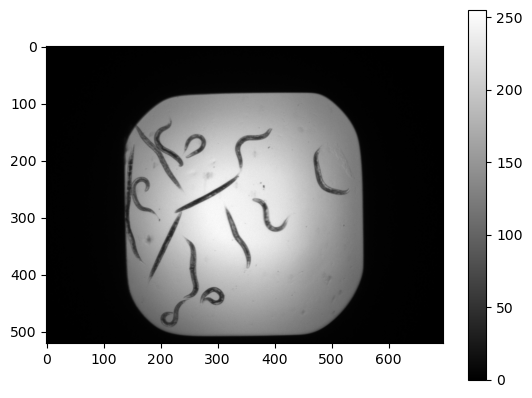

In [439]:
plt.imshow(l_img_stretched[0], cmap="gray")
plt.colorbar()
plt.show()

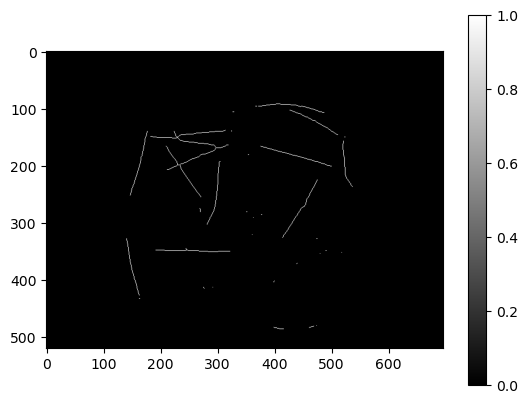

In [440]:
plt.imshow(l_skeleton[12], cmap="gray")
plt.colorbar()
plt.show()

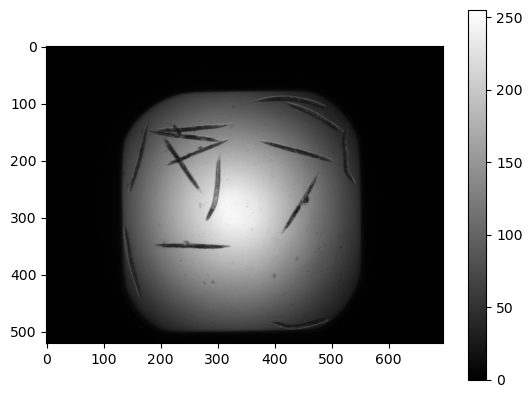

In [441]:
plt.imshow(l_img_stretched[12], cmap="gray")
plt.colorbar()
plt.show()

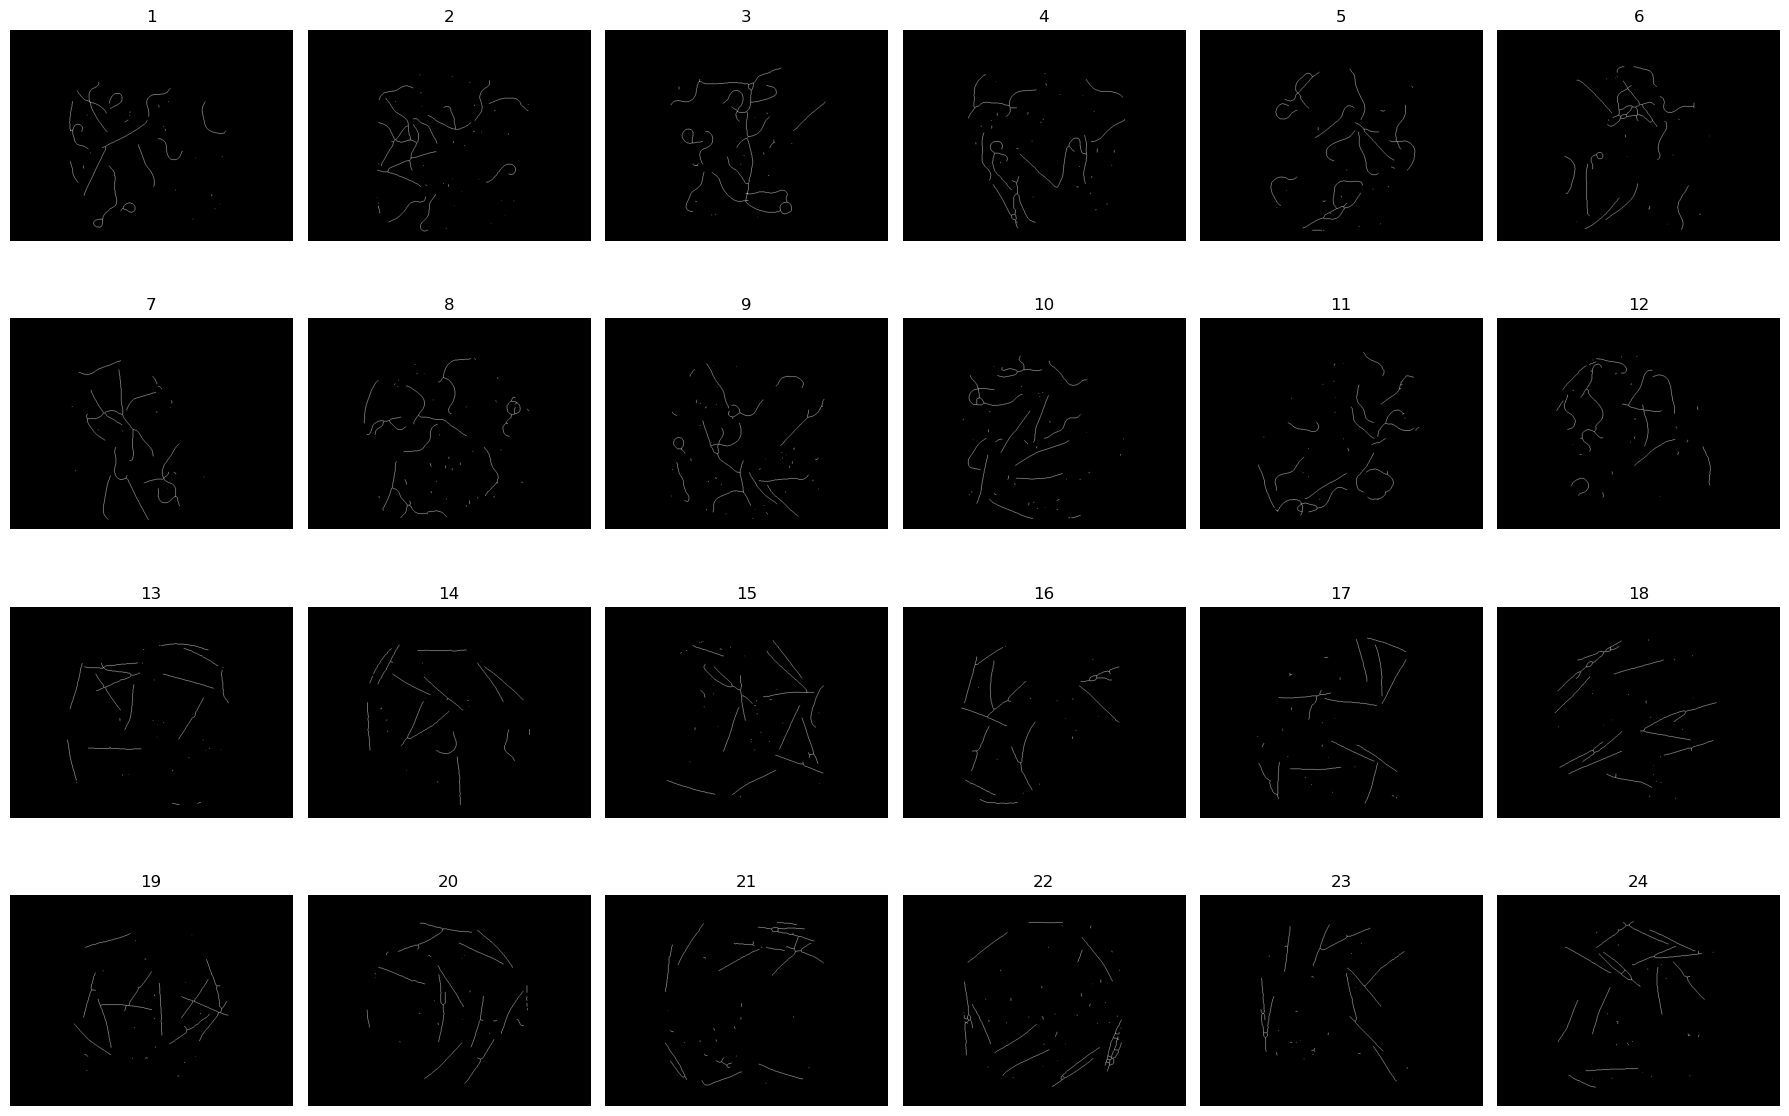

In [442]:
n = len(l_skeleton)
cols = 6       
rows = 4
plt.figure(figsize=(3*cols, 3*rows))
for i, img in enumerate(l_skeleton):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(i+1)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Labélisation des nématodes

Afin de pouvoir analyser les caractéristiques géométriques des nématodes, ces derniers vont être labellisés. Le principal obstacle à cette labélisation est la superposition fréquente des nématodes.  
  
Une approche envisageable est d'analyser la topologie des squelettes obtenus pour tenter d'extraire les squelettes respectifs des nématodes superposés.  
Un graphe de connectivité des pixels (avec plusieurs composantes connexes) est donc construits pour chaque image. 

In [443]:
def adjacency_matrix(image):
    """
    Fonction permettant de récupérer la matrice d'adjacence des pixels pour une image donnée. 
    Il s'agit d'une matrice d'adjacence qui regarde le voisinage pour les 8 pixels autours d'un pixel donné.
    
    :param image: Image composé de pixels (noir et blancs)
    """
    n = len(image)
    m = len(image[0])

    G = nx.Graph()
    for i in range (0, n):
        for j in range (0,m):
            voisins = [(i,j-1), (i, j+1), (i-1, j), (i+1, j), (i+1,j+1), (i+1, j-1), (i-1, j-1), (i-1, j+1)]
            voisins = list(map(lambda x : x if ((0 <= x[0] < n) and ( 0 <= x[1] < m)) else None , voisins)) # On map sur la liste précédente la position du réel du pixel si elle n'est pas en dehors de la map
            adjacence = list(map(lambda x : (image[i][j] and image[x[0]][x[1]]) if x is not None else None , voisins)) # Si les pixels sont tout les deux à 255 (ou 1), ils sont considérés comme voisins. Sinon, non

            for k in range(len(voisins)):
                if ((voisins[k] is not None) and (adjacence[k] == True)):
                    G.add_edge((i,j),(voisins[k][0], voisins[k][1]))
          
    return G

In [444]:
l_skeleton_graph = [adjacency_matrix(skeleton) for skeleton in l_skeleton]

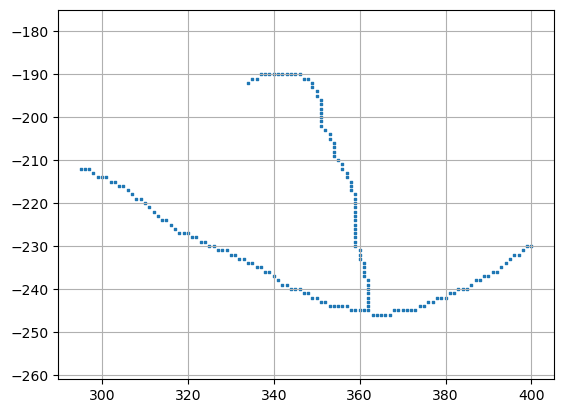

In [445]:
i = 1 # numéro de l'image
j = 11 # numéro de la composante connexe
components = list(nx.connected_components(l_skeleton_graph[i]))
sub_skeleton_graph = l_skeleton_graph[i].subgraph(components[j]).copy()

nodes = list(sub_skeleton_graph)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.grid()
plt.axis("equal")
plt.show()

## Extraction des squelettes candidats

Une fois les graphes obtenus, ils sont parcourus entre chaque extrémité (et fins de cycle) afin d'extraire tous les squelettes possibles de nématodes.

In [446]:
def all_nematods_candidates(G_connexe):
    """
    Fonction qui établit la liste des nématodes potentiels pour un graphe de connectivité donné.
    
    :G_connexe: Graphe de connectivité d'un nématode (ou groupe de nématode)
    """
    def rec_parcours(current, l_parcours):
            """
            Fonction qui récupère l'ensemble des parcours possible dans un graphe de manière récursive
            
            :param current: pixel actuellement observé
            :param l_parcours: Ensemble des chemins de pixels qui sont voisin du pixel current
            """
            if current in l_end:
                if current not in l_end_done:
                    l_parcours.append(current)
                    return l_parcours
            for neighbor in list(G_connexe.neighbors(current)):
                if neighbor in l_parcours[:-1]:
                    l_parcours.append(current)
                    return l_parcours
            
            l_parcours.append(current)
            l_neighbors = list(G_connexe.neighbors(current))
            
            return [rec_parcours(new_current, l_parcours.copy()) for new_current in l_neighbors if new_current not in l_parcours]
    
    l_end = [n for n, d in G_connexe.degree() if d == 1] # On récupère toutes les extrémités des graphes
    l_end_done = []
    l_candidates = []
    for end in l_end:
        l_end_done.append(end)
        l_parcours = [end]
        current = list(G_connexe.neighbors(end))[0]
        
        l_candidates += rec_parcours(current, l_parcours)
    
    def flatten_l_l_tuples(object):
        res = []
        if isinstance(object, list):
            if all(isinstance(x, tuple) for x in object):
                if len(object)>0:
                    res.append(object)
            else:
                for l in object:
                    res.extend(flatten_l_l_tuples(l))
        return res

    return flatten_l_l_tuples(l_candidates)

In [447]:
l_l_skeleton_candidates = []
for i,skeleton_graph in enumerate(l_skeleton_graph):
    l_l_skeleton_candidates.append([])
    for connexe_component in list(nx.connected_components(skeleton_graph)):
        sub_skeleton_graph = skeleton_graph.subgraph(connexe_component).copy()
        l_l_skeleton_candidates[i].append(all_nematods_candidates(sub_skeleton_graph))

In [448]:
print(l_l_skeleton_candidates[1][11][0])

[(192, 334), (191, 335), (191, 336), (190, 337), (190, 338), (190, 339), (190, 340), (190, 341), (190, 342), (190, 343), (190, 344), (190, 345), (190, 346), (191, 347), (191, 348), (192, 349), (193, 349), (194, 350), (195, 350), (196, 351), (197, 351), (198, 351), (199, 351), (200, 351), (201, 351), (202, 351), (203, 352), (204, 353), (205, 353), (206, 354), (207, 354), (208, 354), (209, 354), (210, 355), (211, 356), (212, 356), (213, 357), (214, 357), (215, 358), (216, 358), (217, 358), (218, 359), (219, 359), (220, 359), (221, 359), (222, 359), (223, 359), (224, 359), (225, 359), (226, 359), (227, 359), (228, 359), (229, 359), (230, 359), (231, 360), (232, 360), (233, 360), (234, 361), (235, 361), (236, 361), (237, 361), (238, 362), (239, 362), (240, 362), (241, 362), (242, 362), (243, 362), (244, 362), (245, 362), (246, 363), (246, 364), (246, 365), (246, 366), (246, 367), (245, 368), (245, 369), (245, 370), (245, 371), (245, 372), (245, 373), (244, 374), (244, 375), (243, 376), (24

l_l_skeleton_candidates est donc une liste (pour chaque image) de listes (pour chaque composante connexe) de squelettes possibles de nématodes.

### Trie des candidats

Une fois les candidats obtenus, il s'agit de les trier afin d'identifier les vrais squelettes de nématodes. 

#### Seuil sur la longueur des squelettes

Afin d'éliminer le bruit résiduel, les longueurs des squelettes des composantes connexes avec un seul candidat (ie exactement deux extrémités) sont représentées sous forme d'histogramme.

In [449]:
l_one_nematod_in_one_connexe_part = []

for i in range(len(l_l_skeleton_candidates)):
    for j in range(len(l_l_skeleton_candidates[i])):
        if len(l_l_skeleton_candidates[i][j]) == 1:
            """nodes = smooth_points(list(l_l_skeleton_candidates[i][j][0]))
            x_coords = [n[1] for n in nodes]
            y_coords = [-n[0] for n in nodes]
            plt.figure(figsize=(3,3))
            plt.scatter(x_coords, y_coords, s=1, marker='s')
            plt.axis("equal")
            plt.show()"""
            l_one_nematod_in_one_connexe_part.append(len(l_l_skeleton_candidates[i][j][0]))

print(len(l_one_nematod_in_one_connexe_part))

554


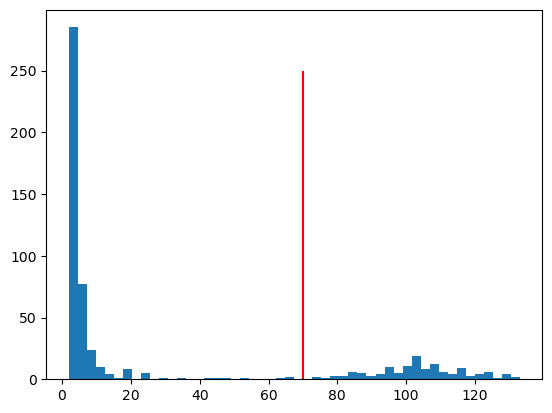

In [450]:
plt.hist(l_one_nematod_in_one_connexe_part, bins = 50)
plt.vlines(70,0,250, colors='red')
plt.show()

Deux groupes de squelettes sont identifiés : le seuil d'une longueur de 70 pixels est choisi pour faire la distinction en le bruit ou les faux candidats et les vrais squelettes de nématodes. 

#### Trie des candidats en fonction des profils de courbure

Cette approche permet d'éliminer les squelettes candidats présentant des profils de coubures aberrants.

Les profils de courbure sont calculés comme l'angle entre deux droites obtenue par régression linéaire sur k points. 

In [451]:
def courbure(points, k=10):
    points = np.array(points)
    n = len(points)
    courbures = []

    for i in range(k, n - k):
        p_prev = points[i - k]
        p = points[i]
        p_next = points[i + k]

        u = p - p_prev
        v = p_next - p

        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        if norm_u == 0 or norm_v == 0:
            courbures.append(0)
            continue

        cos_theta = np.dot(u, v) / (norm_u * norm_v)
        cos_theta = np.clip(cos_theta, -1, 1)
        theta = np.arccos(cos_theta)

        l = (norm_u + norm_v) / 2
        kappa = theta / l

        courbures.append(kappa)

    return np.array(courbures)

Cette approche nécessite cependant un prétraitement des coordonnées des pixels car elle est très sensible à la résolution spatiale. 

En effet, les pixels étant naturellement très éloignées (en coordonnées (x,y) on est à 1 unité de mesure), il est possible de retrouvé des pics de courbure important pour des nématodes relativement plats.

Une fonction d'adoucissement des squelettes candidats est donc appliqué avant le calcul des profils de courbure.

In [452]:
def smooth_points(points, w=3):
    pts = np.array(points)
    res = []
    for i in range(len(pts)):
        i0 = max(0, i-w)
        i1 = min(len(pts), i+w+1)
        res.append(np.mean(pts[i0:i1], axis=0))
    return np.array(res.copy())

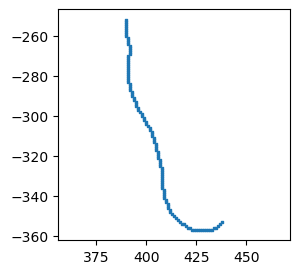

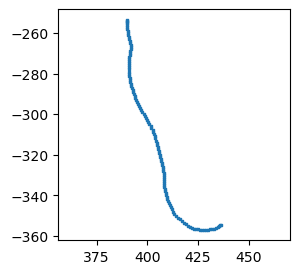

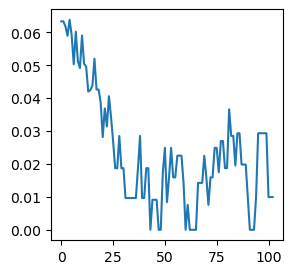

0.023843685572045067


In [453]:
i=4
j=10
nodes = list(l_l_skeleton_candidates[i][j][0])
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]
plt.figure(figsize=(3,3))
plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

nodes = smooth_points(list(l_l_skeleton_candidates[i][j][0]))
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]
plt.figure(figsize=(3,3))
plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

plt.figure(figsize=(3,3))
plt.plot(courbure(l_l_skeleton_candidates[i][j][0]))
plt.show()
print(np.mean(courbure(l_l_skeleton_candidates[i][j][0])))

In [454]:
def choose_candidate(l_l_skeleton_candidates):
    """
    Fonction qui sélectionne des nématodes candidats parmis la liste des nématodes de chaque composante connexe
    
    :param l_l_skeleton_candidates: liste contenant des listes de nématodes candidats (pour chaque composante connexe observée)
    """
    l_l_nematods = []
    for i in range(len(l_l_skeleton_candidates)):
        l_l_nematods.append([])
        for j in range(len(l_l_skeleton_candidates[i])):
            if len(l_l_skeleton_candidates[i][j]) == 1: # partie connexe avec une seule possibilité : du bruit ou un nematode unique
                if len(l_l_skeleton_candidates[i][j][0]) > 70 :
                    l_l_nematods[i].append(l_l_skeleton_candidates[i][j][0])
            else :
                # trie selon la courbure maximale du candidat
                l_candidate = [candidate for candidate in l_l_skeleton_candidates[i][j] if 80<len(candidate)<120]
                l_candidate_courbure = [courbure(smooth_points(candidate)) for candidate in l_candidate]
                l_max_courbure = [np.max(profil) for profil in l_candidate_courbure]
                ordre = {valeur: i for i, valeur in enumerate(l_max_courbure)}
                l_max_courbure_sorted = sorted(l_max_courbure)
                l_candidate_courbure_sorted = [x for _, x in sorted(zip(l_max_courbure_sorted, l_candidate_courbure), key=lambda pair: ordre[pair[0]])]
                l_candidate = [x for _, x in sorted(zip(l_max_courbure_sorted, l_candidate), key=lambda pair: ordre[pair[0]])]

                estimation_nb_nematods = len(set(pixel for candidate in l_l_skeleton_candidates[i][j] for pixel in candidate))//120
                l_l_nematods[i] += l_candidate[:estimation_nb_nematods]
                
    return l_l_nematods

In [455]:
l_l_nematods = choose_candidate(l_l_skeleton_candidates)

Les paramètres de la fonction ci-dessus ont été optimisés heuristiquement pour obtenir la meilleure labélisation possible. 

Une approche prudente a été adpoté, car il est préférable dans le cadre de l'analyse statistique suivante d'avoir loupé une identification d'un nématode plutôt que de faire une fausse identification avec des caractéristiques géométriques aberrantes.

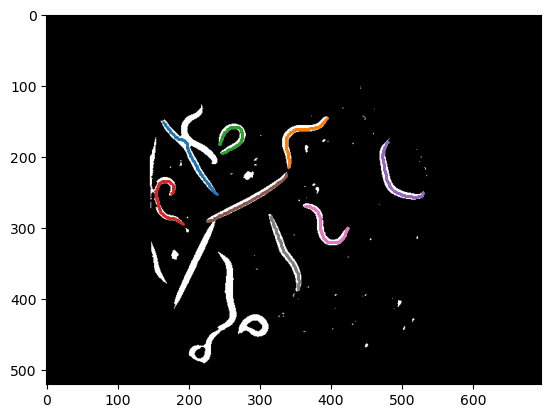

In [456]:
plt.imshow(l_img_morph[0], cmap="gray")
for j in range(len(l_l_nematods[0])):
    nodes = list(l_l_nematods[0][j])
    x_coords = [n[1] for n in nodes]
    y_coords = [n[0] for n in nodes]
    plt.scatter(x_coords, y_coords, s=1)

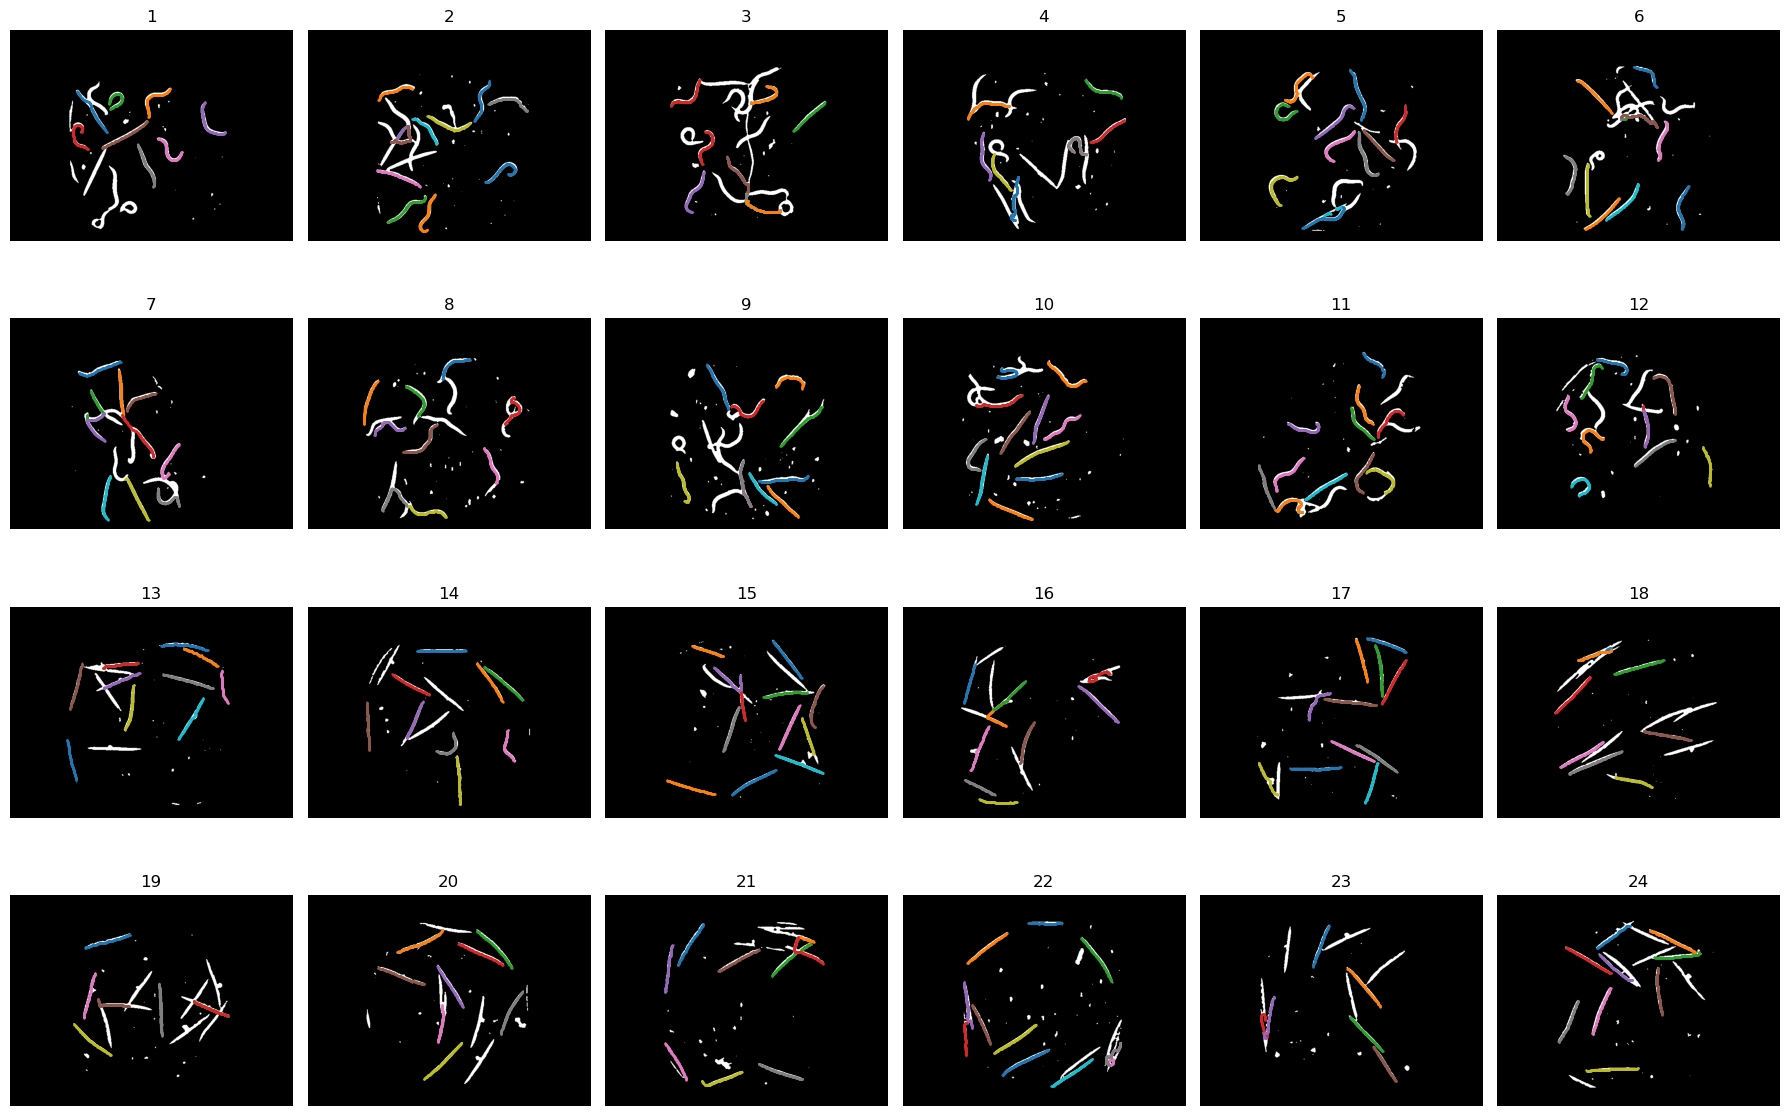

In [457]:
n = len(l_img_morph_fill)
cols = 6       
rows = 4
plt.figure(figsize=(3*cols, 3*rows))
for i, img in enumerate(l_img_morph_fill):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(i+1)
    plt.axis("off")
    for j in range(len(l_l_nematods[i])):
        nodes = list(l_l_nematods[i][j])
        x_coords = [n[1] for n in nodes]
        y_coords = [n[0] for n in nodes]
        plt.scatter(x_coords, y_coords, s=.5)

plt.tight_layout()
plt.show()

# Calcul des caractéristiques géométriques

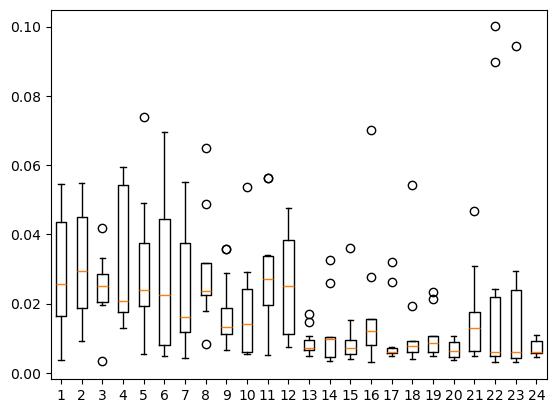

In [458]:
plt.boxplot([[np.mean(courbure(nematod)) for nematod in l_l_nematods[i]] for i in range(len(l_l_nematods))])
plt.show()

In [459]:
def flatten (xss):
    return [x for xs in xss for x in xs]

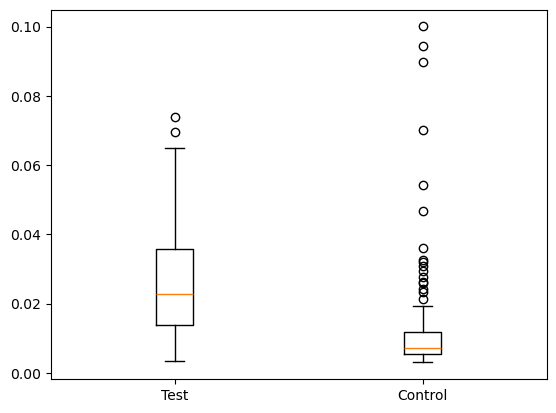

In [460]:
plt.boxplot([[np.mean(courbure(nematod)) for nematod in flatten(l_l_nematods[:12])] , [np.mean(courbure(nematod)) for nematod in flatten(l_l_nematods[12:])]])
plt.xticks(
    ticks=[1, 2],
    labels=["Test", "Control"]
)
plt.show()

# Analyse des résultats

Pour prendre en compte la structure hiérachique des données, un modèle mixte est construit avec les numéros d'images en effets aléatoires.

In [461]:
test = [[np.mean(courbure(nematod)) for nematod in l_l_nematods[i]] for i in range(12)]
control = [[np.mean(courbure(nematod)) for nematod in l_l_nematods[12+i]] for i in range(12)]

In [462]:
data = []
for i, sub in enumerate(test):
    for courbure in sub:
        data.append({"courbure": courbure, "groupe": "test", "image": f"test_{i}"})
for i, sub in enumerate(control):
    for courbure in sub:
        data.append({"courbure": courbure, "groupe": "controle", "image": f"ctrl_{i}"})

df = pd.DataFrame(data)

model = smf.mixedlm("courbure ~ groupe", df, groups=df["image"])
result = model.fit()

print(result.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: courbure
No. Observations:  249     Method:             REML    
No. Groups:        24      Scale:              0.0003  
Min. group size:   6       Log-Likelihood:     656.7535
Max. group size:   15      Converged:          Yes     
Mean group size:   10.4                                
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.013    0.002 7.867 0.000  0.010  0.016
groupe[T.test] 0.013    0.002 5.754 0.000  0.009  0.018
Group Var      0.000    0.001                          



/home/lilian/anaconda3/envs/ccc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lilian/anaconda3/envs/ccc/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lilian/anaconda3/envs/ccc/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


L’analyse met en évidence un effet significatif du groupe (p < 0.001), indiquant que la moyenne de courbure est significativement plus élevée dans le groupe test que dans le groupe contrôle.
  
Ces résultats montrent une différence robuste entre les deux groupes, indépendamment de la variabilité inter-image.

# Conclusion

Le pipeline proposé a permis de segementer les images de nématodes puis d'analyser individuellement leur caractéristiques géométriques afin de mettre en évidence une différence significative de courbure moyenne des nématodes entre les groupes.  
  
On peut donc conlcure à un effet significatif du traitement antibiotique.

De nombreuses autres approches étaient envisageables pour répondre aux défis de ce projet. En particlier, des approches de deep learning semblent très adaptées pour réaliser ce genre de tâche.